## Problem Statement

Based on monthly information for a segment of drivers of a cab sharing company, we need to predict whether a driver will be leaving the company or not based on their attributes like performance history, demographics and tenure.

Concepts : Bagging, Boosting, Decision Tree, Random Forest

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,confusion_matrix,
    roc_auc_score,roc_curve,auc
    )
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

In [ ]:
data=pd.read_csv("driver.csv")
print(data.columns)
data.head()

In [ ]:
data.drop(columns=['Unnamed: 0'],inplace=True)
data.head()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


In [ ]:
data['MMM-YY']=pd.to_datetime(data['MMM-YY'])
data['Dateofjoining']=pd.to_datetime(data['Dateofjoining'])
data['LastWorkingDate']=pd.to_datetime(data['LastWorkingDate'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

<ipython-input-5-32fbf07b9a81>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['MMM-YY']=pd.to_datetime(data['MMM-YY'])
<ipython-input-5-32fbf07b9a81>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Dateofjoining']=pd.to_datetime(data['Dateofjoining'])
<ipython-input-5-32fbf07b9a81>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['LastWorkingDate']=pd.to_datetime(data['LastWorkingDate'])


In [ ]:
data.isnull().sum()/len(data)*100

MMM-YY                   0.000000
Driver_ID                0.000000
Age                      0.319305
Gender                   0.272194
City                     0.000000
Education_Level          0.000000
Income                   0.000000
Dateofjoining            0.000000
LastWorkingDate         91.541039
Joining Designation      0.000000
Grade                    0.000000
Total Business Value     0.000000
Quarterly Rating         0.000000
dtype: float64

There are missing values in columns Age and Gender.

In [ ]:
data['Gender'].value_counts()

Gender
0.0    11074
1.0     7978
Name: count, dtype: int64

In [ ]:
data['Education_Level'].value_counts()

Education_Level
1    6864
2    6327
0    5913
Name: count, dtype: int64

### KNN Imputation

In [ ]:
data_nums=data.select_dtypes(np.number)
data_nums.drop(columns=['Driver_ID'],inplace=True)
cols=data_nums.columns
cols

Index(['Age', 'Gender', 'Education_Level', 'Income', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imputer.fit(data_nums)

KNNImputer()

In [ ]:
data_new=imputer.transform(data_nums)
print(type(data_new))
data_new=pd.DataFrame(data_new)
data_new.columns=cols
data_new.head()

In [ ]:
data_new.isnull().sum()/len(data_new)*100

Age                     0.0
Gender                  0.0
Education_Level         0.0
Income                  0.0
Joining Designation     0.0
Grade                   0.0
Total Business Value    0.0
Quarterly Rating        0.0
dtype: float64

In [ ]:
rem_cols=list(set(data.columns).difference(set(cols)))
rem_cols

['LastWorkingDate', 'Driver_ID', 'MMM-YY', 'City', 'Dateofjoining']

In [ ]:
df=pd.concat([data_new,data[rem_cols]],axis=1)
df.head()

In [ ]:
print(data[data['Driver_ID']==2788])
print(df[df['Driver_ID']==2788])

          MMM-YY  Driver_ID   Age  Gender City  Education_Level  Income  \
19097 2020-06-01       2788  29.0     0.0  C27                2   70254   
19098 2020-07-01       2788  30.0     0.0  C27                2   70254   
19099 2020-08-01       2788  30.0     0.0  C27                2   70254   
19100 2020-09-01       2788  30.0     0.0  C27                2   70254   
19101 2020-10-01       2788  30.0     0.0  C27                2   70254   
19102 2020-11-01       2788  30.0     0.0  C27                2   70254   
19103 2020-12-01       2788  30.0     0.0  C27                2   70254   

      Dateofjoining LastWorkingDate  Joining Designation  Grade  \
19097    2020-06-08             NaT                    2      2   
19098    2020-06-08             NaT                    2      2   
19099    2020-06-08             NaT                    2      2   
19100    2020-06-08             NaT                    2      2   
19101    2020-06-08             NaT                    2      2 

Concat looks correct.

In [ ]:
function_dict = {'Age':'max', 'Gender':'first','City':'first',
 'Education_Level':'last', 'Income':'last',
 'Joining Designation':'last','Grade':'last',
 'Dateofjoining':'last','LastWorkingDate':'last',
 'Total Business Value':'sum','Quarterly Rating':'last'}
new_train=df.groupby(['Driver_ID','MMM-YY']).aggregate(function_dict)
new_train.head(10)

In [ ]:
df_new=new_train.sort_index( ascending=[True,True])
df_new.head(10)

### Aggregation at driver level

In [ ]:
df1=pd.DataFrame()
df1['Driver_ID']=df['Driver_ID'].unique()

In [ ]:
df1['Age'] = list(df_new.groupby('Driver_ID',axis=0).max('MMM-YY')['Age'])
df1['Gender'] = list(df_new.groupby('Driver_ID').agg({'Gender':'last'})['Gender'])
df1['City'] = list(df_new.groupby('Driver_ID').agg({'City':'last'})['City'])
df1['Education'] = list(df_new.groupby('Driver_ID').agg({'Education_Level':'last'})['Education_Level'])
df1['Income'] = list(df_new.groupby('Driver_ID').agg({'Income':'last'})['Income'])
df1['Joining_Designation'] = list(df_new.groupby('Driver_ID').agg({'Joining Designation':'last'})['Joining Designation'])
df1['Grade'] = list(df_new.groupby('Driver_ID').agg({'Grade':'last'})['Grade'])
df1['Total_Business_Value'] = list(df_new.groupby('Driver_ID',axis=0).sum('Total Business Value')['Total Business Value'])
df1['Last_Quarterly_Rating'] = list(df_new.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating'])
df1

Creating a column which tells if the quarterly rating has increased for that employee."quarterly rating" = 1 means it has increased.

In [ ]:
#First Quarterly rating
qrf = df_new.groupby('Driver_ID').agg({'Quarterly Rating':'first'})
#Latest Quarterly rating
qrl = df_new.groupby('Driver_ID').agg({'Quarterly Rating':'last'})

qr = (qrl['Quarterly Rating']>qrf['Quarterly Rating']).reset_index()
empid = qr[qr['Quarterly Rating']==True]['Driver_ID']

qri = []
for i in df1['Driver_ID']:
 if i in empid.values:
  qri.append(1)
 else:
  qri.append(0)
df1['Quarterly_Rating_Increased'] = qri
df1.head(10)

Creating a column called target which tells if the person has left the company. Persons who have a last working date will have the value 1 otherwise 0.

In [ ]:
df_new.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate']

Driver_ID
1      2019-03-11
2             NaT
4      2020-04-27
5      2019-03-07
6             NaT
          ...    
2784          NaT
2785   2020-10-28
2786   2019-09-22
2787   2019-06-20
2788          NaT
Name: LastWorkingDate, Length: 2381, dtype: datetime64[ns]

In [ ]:
lwr = (df_new.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
#The employee ids who do not have last working date
empid = lwr[lwr['LastWorkingDate']==True]['Driver_ID']
target = []
for i in df1['Driver_ID']:
 if i in empid.values:
  target.append(0)
 elif i not in empid.values:
  target.append(1)

df1['Target'] = target
df1.head()

Creating a column which tells if the monthly income has increased for that employee. For those whose monthly income has increased we assign the value 1.

In [ ]:
sf = df_new.groupby('Driver_ID').agg({'Income':'first'})
sl = df_new.groupby('Driver_ID').agg({'Income':'last'})
s = (sl['Income']>sf['Income']).reset_index()
#the employee ids whose monthly income has increased
empid = s[s['Income']==True]['Driver_ID']
si = []
for i in df1['Driver_ID']:
 if i in empid.values:
  si.append(1)
 else:
  si.append(0)
df1['Income_Increased'] = si
df1.head()

In [ ]:
df1['Income_Increased'].value_counts()

Income_Increased
0    2338
1      43
Name: count, dtype: int64

In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Age,2381.0,3.377018e+01,5.933265e+00,21.0,30.0,33.0,37.0,58.0
Gender,2381.0,4.105838e-01,4.914963e-01,0.0,0.0,0.0,1.0,1.0
Education,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Income,2381.0,5.933416e+04,2.838367e+04,10747.0,39104.0,55315.0,75986.0,188418.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0
Grade,2381.0,2.096598e+00,9.415218e-01,1.0,1.0,2.0,3.0,5.0
Total_Business_Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Last_Quarterly_Rating,2381.0,1.427971e+00,8.098389e-01,1.0,1.0,1.0,2.0,4.0
Quarterly_Rating_Increased,2381.0,1.503570e-01,3.574961e-01,0.0,0.0,0.0,0.0,1.0


In [ ]:
df1.describe(include=['O'])

,City
count,2381
unique,29
top,C20
freq,152


In [ ]:
df1['Target'].value_counts()

Target
1    1616
0     765
Name: count, dtype: int64

In [ ]:
df1['Target'].value_counts(normalize=True)*100

Target
1    67.870643
0    32.129357
Name: proportion, dtype: float64

<Axes: xlabel='Target'>

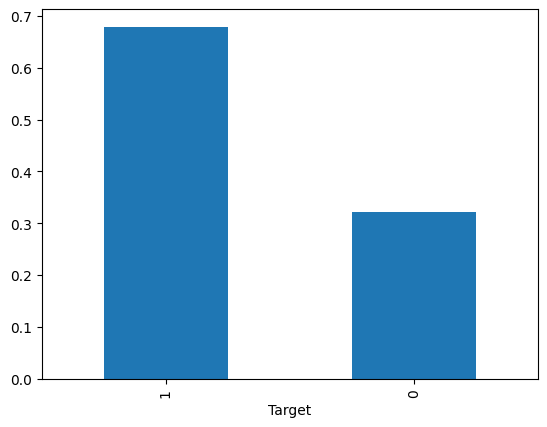

In [ ]:
df1['Target'].value_counts(normalize=True).plot(kind='bar')

There are 2381 employees in the dataset. The minimum age of the employee in the data is 21 years and the maximum age is 58 years. 75% of the employees have their monthly income less than or equal to 75,986 units. 50% of the mployees have acquired 8,17,680 as the their total business value. Most of the drivers in the dataset were male, lived in C20 city and have completed their graduation in education. Out of 2381 drivers, 1616 drivers have left the organization. Around 68% driver have left the organization.


### Categorical features analysis

In [ ]:
n = ['Gender','City','Education','Joining_Designation','Grade','Last_Quarterly_Rating','Quarterly_Rating_Increased']
for i in n:
 print(df1[i].value_counts())
 print("------------------------------------------------------------")

Gender
0.0    1400
1.0     975
0.6       3
0.2       2
0.4       1
Name: count, dtype: int64
------------------------------------------------------------
City
C20    152
C15    101
C29     96
C26     93
C8      89
C27     89
C10     86
C16     84
C22     82
C3      82
C28     82
C12     81
C5      80
C1      80
C21     79
C14     79
C6      78
C4      77
C7      76
C9      75
C25     74
C23     74
C24     73
C19     72
C2      72
C17     71
C13     71
C18     69
C11     64
Name: count, dtype: int64
------------------------------------------------------------
Education
2.0    802
1.0    795
0.0    784
Name: count, dtype: int64
------------------------------------------------------------
Joining_Designation
1.0    1026
2.0     815
3.0     493
4.0      36
5.0      11
Name: count, dtype: int64
------------------------------------------------------------
Grade
2.0    855
1.0    741
3.0    623
4.0    138
5.0     24
Name: count, dtype: int64
---------------------------------------------------

In [ ]:
n = ['Gender','City','Education','Joining_Designation','Grade','Last_Quarterly_Rating','Quarterly_Rating_Increased']
for i in n:
 print(df1[i].value_counts(normalize=True))
 print("------------------------------------------------------------")

Gender
0.0    0.587988
1.0    0.409492
0.6    0.001260
0.2    0.000840
0.4    0.000420
Name: proportion, dtype: float64
------------------------------------------------------------
City
C20    0.063839
C15    0.042419
C29    0.040319
C26    0.039059
C8     0.037379
C27    0.037379
C10    0.036119
C16    0.035279
C22    0.034439
C3     0.034439
C28    0.034439
C12    0.034019
C5     0.033599
C1     0.033599
C21    0.033179
C14    0.033179
C6     0.032759
C4     0.032339
C7     0.031919
C9     0.031499
C25    0.031079
C23    0.031079
C24    0.030659
C19    0.030239
C2     0.030239
C17    0.029819
C13    0.029819
C18    0.028979
C11    0.026879
Name: proportion, dtype: float64
------------------------------------------------------------
Education
2.0    0.336833
1.0    0.333893
0.0    0.329273
Name: proportion, dtype: float64
------------------------------------------------------------
Joining_Designation
1.0    0.430911
2.0    0.342293
3.0    0.207056
4.0    0.015120
5.0    0.004620
Name

Around 59% employees are of the Male gender.

Around 6.4% employees are from city C20 and 4.2% from city C15.

The proportion of the employees who have completed their Graduation and 12th are approximately same.

Around 43% of the employees joined with the grade 1.

At the time of reporting, 34% of the employees had their grade as 2.

Around 73% of the employees had their last quarterly rating as 1.

The quarterly rating has not increased for around 87% employees.


<ipython-input-32-9d1ca0246ff8>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(231)


<Axes: title={'center': 'Quarterly Rating Increased'}, xlabel='Quarterly_Rating_Increased'>

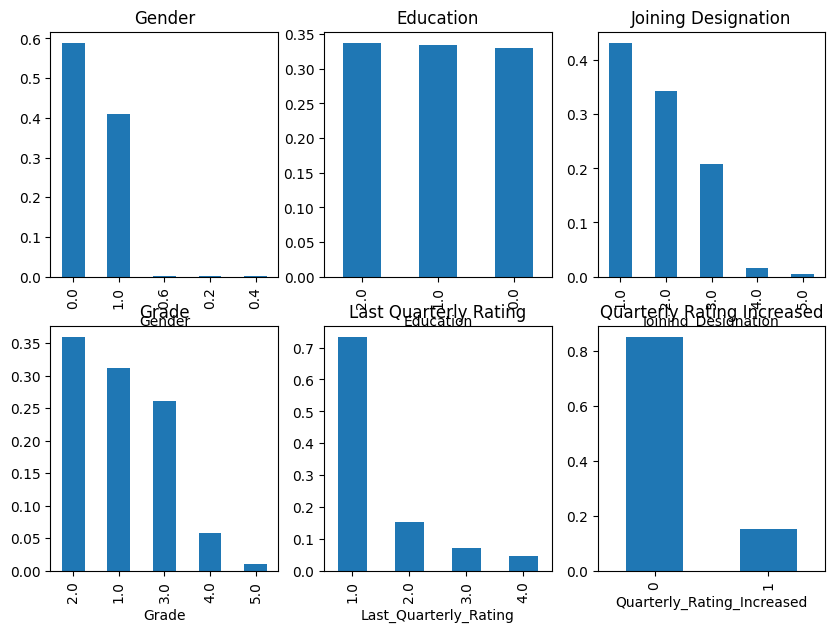

In [ ]:
plt.subplots(figsize=(10,7))
plt.subplot(231)
df1['Gender'].value_counts(normalize=True).plot.bar(title='Gender')

plt.subplot(232)
df1['Education'].value_counts(normalize=True).plot.bar(title='Education')

plt.subplot(233)
df1['Joining_Designation'].value_counts(normalize=True).plot.bar(title='Joining Designation')

plt.subplot(234)
df1['Grade'].value_counts(normalize=True).plot.bar(title='Grade')

plt.subplot(235)
df1['Last_Quarterly_Rating'].value_counts(normalize=True).plot.bar(title='Last Quarterly Rating')

plt.subplot(236)
df1['Quarterly_Rating_Increased'].value_counts(normalize=True).plot.bar(title='Quarterly Rating Increased')


<Axes: title={'center': 'City'}, xlabel='City'>

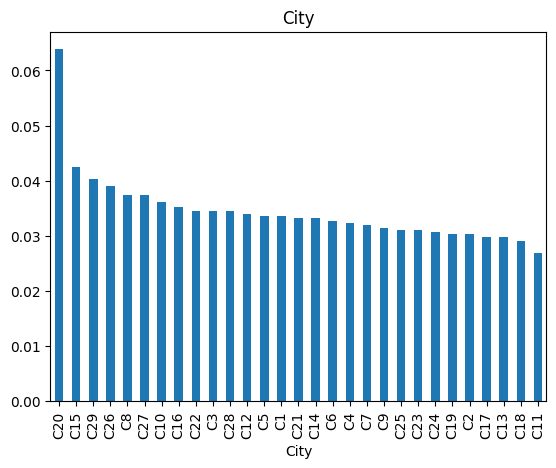

In [ ]:
df1['City'].value_counts(normalize=True).plot.bar(title='City')

<ipython-input-34-376f5b7e7f3b>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)
<ipython-input-34-376f5b7e7f3b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['Age'],color='black')


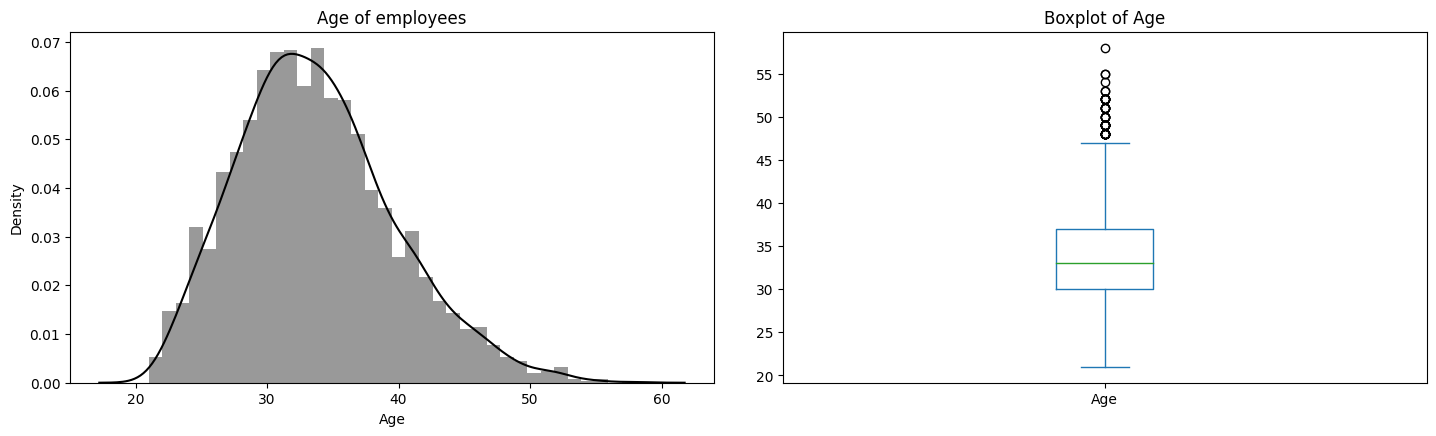

In [ ]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.distplot(df1['Age'],color='black')
plt.title("Age of employees")
plt.subplot(122)
df1['Age'].plot.box(title='Boxplot of Age')
plt.tight_layout(pad=3)

There are few outliers in the Age. The distribution is towards the right

<ipython-input-35-1a2f5bdc069d>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)
<ipython-input-35-1a2f5bdc069d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['Income'],color='black')


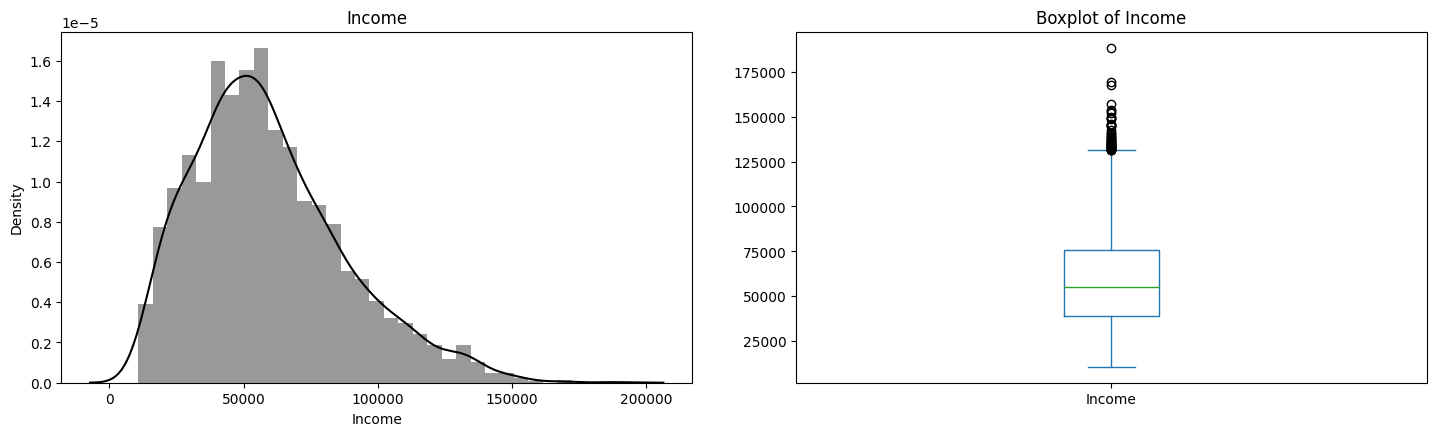

In [ ]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.distplot(df1['Income'],color='black')
plt.title("Income")
plt.subplot(122)
df1['Income'].plot.box(title='Boxplot of Income')
plt.tight_layout(pad=3)

The distribution of Salary is towards the right and there are outliers for this feature as well

<ipython-input-36-c36e90af5843>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)
<ipython-input-36-c36e90af5843>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['Total_Business_Value'],color='black')


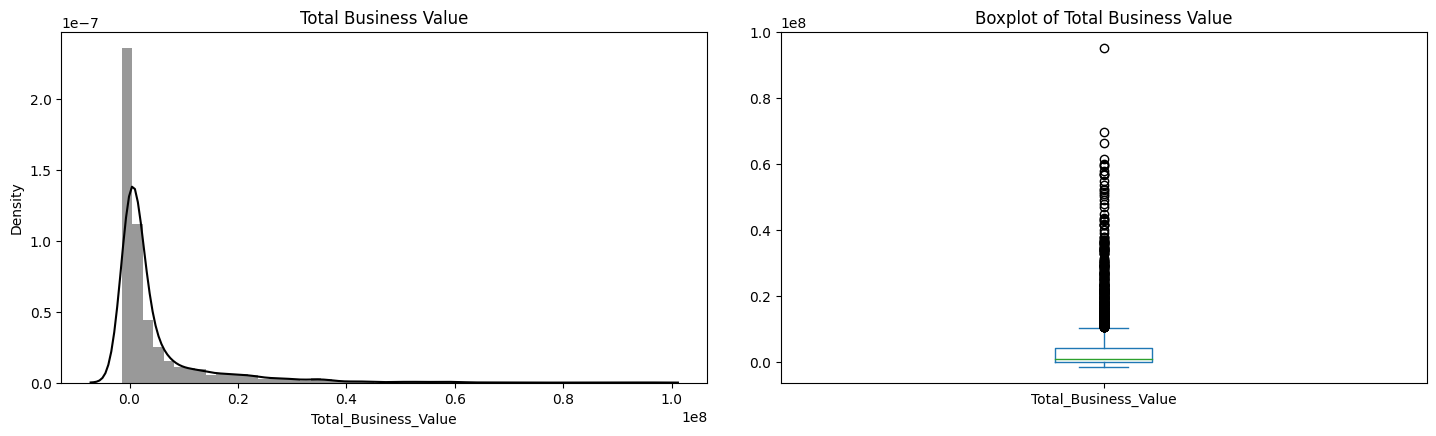

In [ ]:
plt.subplots(figsize=(15,5))
plt.subplot(121)
sns.distplot(df1['Total_Business_Value'],color='black')
plt.title("Total Business Value")
plt.subplot(122)
df1['Total_Business_Value'].plot.box(title='Boxplot of Total Business Value')
plt.tight_layout(pad=3)

The distribution of total business value is towards the right. There are a lot of outliers for the feature
Total Business Value

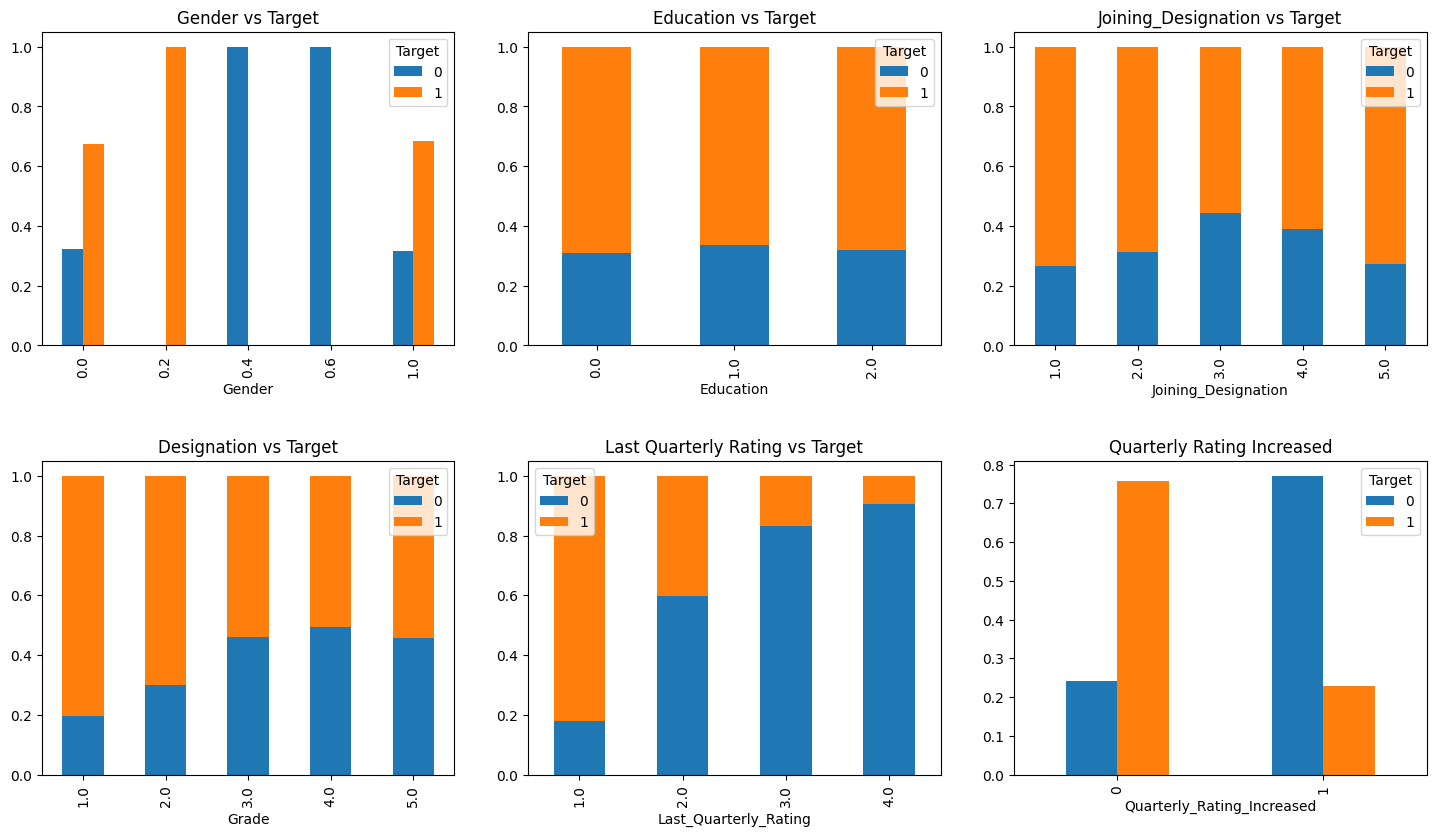

In [ ]:
figure,axes=plt.subplots(2,3,figsize=(15,9))
#Gender with Target
gender = pd.crosstab(df1['Gender'],df1['Target'])
gender.div(gender.sum(1).astype(float),axis=0).plot(kind='bar',stacked=False,ax=axes[0,0],title='Gender vs Target')

# Education with Target
education = pd.crosstab(df1['Education'],df1['Target'])
education.div(education.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[0,1],title='Education vs Target')

# Joining Designation with Target
jde = pd.crosstab(df1['Joining_Designation'],df1['Target'])
jde.div(jde.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[0,2],title='Joining_Designation vs Target')

#Designation feature with Target
desig = pd.crosstab(df1['Grade'],df1['Target'])
desig.div(desig.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[1,0],title='Designation vs Target')

#Last Quarterly Rating feature with Target
lqrate = pd.crosstab(df1['Last_Quarterly_Rating'],df1['Target'])
lqrate.div(lqrate.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,ax=axes[1,1],title='Last Quarterly Rating vs Target')

#Quarterly Rating Increased feature with Target
qratei = pd.crosstab(df1['Quarterly_Rating_Increased'],df1['Target'])
qratei.div(qratei.sum(1).astype(float),axis=0).plot(kind='bar',stacked=False,ax=axes[1,2],title="Quarterly Rating Increased")

plt.tight_layout(pad=3)


The proportion of gender and education is more or less the same for both the employees who left the organization and those who did not leave. The employees who have their grade as 3 or 4 at the time of joining are less likely to leave the
organization. The employees who have their last quarterly rating as 3 or 4 at the time of reporting are less likely to
leave the organization. The employees whose quarterly rating has increased are less likely to leave the organization.

<Figure size 3000x700 with 0 Axes>

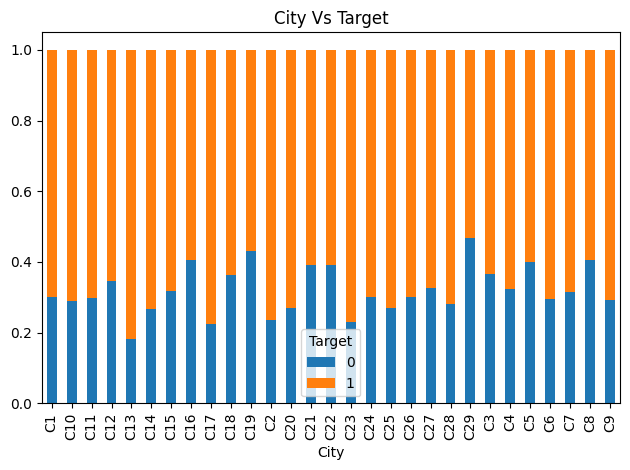

In [ ]:
#City feature with the target
plt.figure(figsize=(30,7))
city = pd.crosstab(df1['City'],df1['Target'])
city.div(city.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="City Vs Target")
plt.tight_layout()

<Axes: title={'center': 'Age with Target'}, xlabel='Age_Bin'>

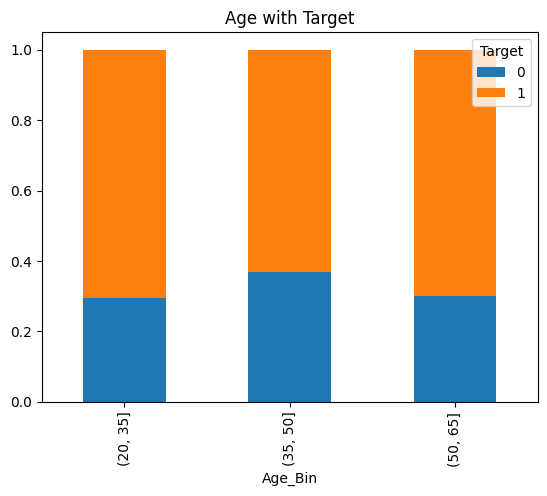

In [ ]:
#Binning the Age into categories
df1['Age_Bin'] = pd.cut(df1['Age'],bins=[20,35,50,65])
#Age feature with Target
agebin = pd.crosstab(df1['Age_Bin'],df1['Target'])
agebin.div(agebin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="Age with Target")

The employees whose age is in the 20-35 or 50-65 groups are less likely to leave the organization.

<Axes: title={'center': 'Income vs Target'}, xlabel='Income_Bin'>

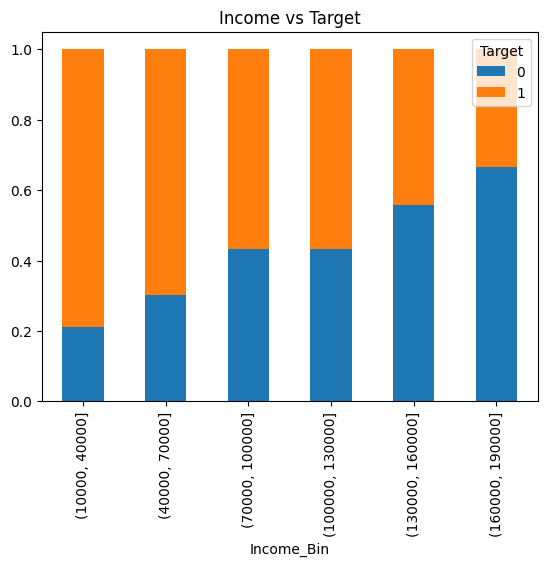

In [ ]:
#Binning the Income into categories
df1['Income_Bin'] = pd.cut(df1['Income'],bins=[10000, 40000, 70000, 100000, 130000, 160000, 190000])
#Salary feature with Target
salarybin = pd.crosstab(df1['Income_Bin'],df1['Target'])
salarybin.div(salarybin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="Income vs Target")

The employees whose monthly income is in 1,60,000-1,90,000 or 1,30,000-1,60,000 are less likely to leave
the organization.

<Axes: title={'center': 'Total business value vs Target'}, xlabel='TBV_Bin'>

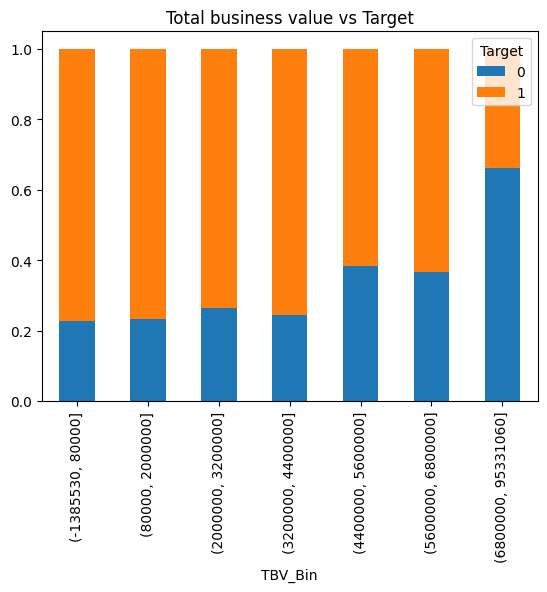

In [ ]:
#Defining the bins and groups
m1 = round(df1['Total_Business_Value'].min())
m2 = round(df1['Total_Business_Value'].max())
bins = [m1, 80000 , 2000000 , 3200000, 4400000, 5600000, 6800000, m2]
#Binning the Total Business Value into categories
df1['TBV_Bin'] = pd.cut(df1['Total_Business_Value'],bins)
#Total Business Value feature with Target
tbvbin = pd.crosstab(df1['TBV_Bin'],df1['Target'])
tbvbin.div(tbvbin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,title="Total business value vs Target")

The employees who have acquired total business value greater than 68,00,000 are less likely to leave the organiztion.

In [ ]:
#Dropping the bins columns
df1.drop(['Age_Bin','Income_Bin','TBV_Bin'],axis=1,inplace=True)

In [ ]:
df1.head()

### One Hot Encoding

Converting categorical variables to numeric values so that Machine Learning models can be applied

In [ ]:
df1 = pd.concat([df1,pd.get_dummies(df1['City'],prefix='City')],axis=1)
df1.head()

### Scaling on training set
The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.


In [ ]:
X = df1.drop(['Driver_ID','Target','City'],axis=1)
X_cols=X.columns

scaler = MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
X=pd.DataFrame(X)
X.columns=X_cols
X

,Age,Gender,Education,Income,Joining_Designation,Grade,Total_Business_Value,Last_Quarterly_Rating,Quarterly_Rating_Increased,Income_Increased,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,0.189189,0.0,1.0,0.262508,0.00,0.00,0.032064,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.270270,0.0,1.0,0.316703,0.25,0.25,0.014326,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.594595,0.0,1.0,0.308750,0.25,0.25,0.017944,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.216216,0.0,0.0,0.200489,0.00,0.00,0.015570,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.270270,1.0,0.5,0.382623,0.50,0.50,0.027405,0.333333,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,0.351351,0.0,0.0,0.405626,0.25,0.50,0.239197,1.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2377,0.351351,1.0,0.0,0.007643,0.00,0.00,0.014326,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2378,0.648649,0.0,0.0,0.138588,0.25,0.25,0.043432,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2379,0.189189,1.0,1.0,0.330673,0.00,0.00,0.024436,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Target Variable
y = df1['Target']
# split into 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [ ]:
y_train.value_counts()

Target
1    1289
0     615
Name: count, dtype: int64

In [ ]:
y_train.value_counts(normalize=True)

Target
1    0.676996
0    0.323004
Name: proportion, dtype: float64

Dataset is slightly imbalanced. We can use random Forest with class_weight='balanced' or SMOTE to make it balanced.

# Random Forest Classifier

In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}
random_forest = RandomForestClassifier(class_weight ='balanced')
c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)
def display(results):
 print(f'Best parameters are : {results.best_params_}')
 print(f'The score is : {results.best_score_}')
display(c)
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Best parameters are : {'max_depth': 4, 'n_estimators': 200}
The score is : 0.8599093887152146
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       150
           1       0.82      0.89      0.85       327

    accuracy                           0.79       477
   macro avg       0.76      0.74      0.75       477
weighted avg       0.79      0.79      0.79       477

[[ 88  62]
 [ 37 290]]


The Random Forest With "balanced" Class Weight :

Out of all predicted 0 70% are correct and out of all 1 82% are correct (Precision).

Out of all actual 0 59% are identified, and out of all 1 89% are rightly identified (Recall).


In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}
random_forest = RandomForestClassifier(class_weight ='balanced_subsample')
c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)
def display(results):
 print(f'Best parameters are : {results.best_params_}')
 print(f'The score is : {results.best_score_}')
display(c)
y_pred = c.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

Best parameters are : {'max_depth': 4, 'n_estimators': 50}
The score is : 0.8592111507553025
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       150
           1       0.83      0.90      0.86       327

    accuracy                           0.80       477
   macro avg       0.77      0.74      0.75       477
weighted avg       0.79      0.80      0.79       477

[[ 88  62]
 [ 34 293]]


The Random Forest With "balanced_subsample" Class Weight :

Out of all predicted 0 72% are correct and out of all 1 83% are correct (Precision).

Out of all actual 0 59% are identified, and out of all 1 90% are rightly identified (Recall).

In [ ]:
## Using SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 7)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 1289
Before OverSampling, counts of label '0': 615 

After OverSampling, the shape of train_X: (2578, 39)
After OverSampling, the shape of train_y: (2578,) 

After OverSampling, counts of label '1': 1289
After OverSampling, counts of label '0': 1289


In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}
random_forest = RandomForestClassifier(class_weight ='balanced')
c = GridSearchCV(random_forest,param,cv=3,scoring='f1')
c.fit(X_train,y_train)
def display(results):
 print(f'Best parameters are : {results.best_params_}')
 print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'max_depth': 4, 'n_estimators': 50}
The score is : 0.817515652155765


In [ ]:
pred = c.predict(X_test)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.73      0.59      0.65       150
           1       0.83      0.90      0.86       327

    accuracy                           0.80       477
   macro avg       0.78      0.74      0.76       477
weighted avg       0.80      0.80      0.80       477

[[ 88  62]
 [ 32 295]]


## XG Boost Classifier

In [ ]:
my_model = xgb.XGBClassifier(class_weight ='balanced')
my_model.fit(X_train, y_train)

y_pred = my_model.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.72      0.51      0.60       150
           1       0.80      0.91      0.85       327

    accuracy                           0.78       477
   macro avg       0.76      0.71      0.72       477
weighted avg       0.78      0.78      0.77       477

[[ 76  74]
 [ 29 298]]


XG Boost classifier :

Out of all predicted 0 72% are correct and out of all 1 80% are correct (Precision).

Out of all actual 0 51% are identified correctly, and out of all 1 91% are rightly identified (Recall).

## Decision Tree Classifier

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.54      0.56      0.55       150
           1       0.80      0.78      0.79       327

    accuracy                           0.71       477
   macro avg       0.67      0.67      0.67       477
weighted avg       0.72      0.71      0.71       477

[[ 84  66]
 [ 71 256]]


Decision Tree Classifier classifier :

Out of all predicted 0 54% are correct and out of all 1 80% are correct (Precision).

Out of all actual 0 56% are identified correctly, and out of all 1 78% are rightly identified (Recall).

We observe that we are not getting very high recall on target 0 which may be due to small unbalanced
dataset.

Higher precision means that an algorithm returns more relevant results than irrelevant ones.

High recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also
returned).


### Feature Importances

In [ ]:
param = {'max_depth':[2,3,4], 'n_estimators':[50,100,150,200]}
random_forest = RandomForestClassifier(class_weight ='balanced')
random_forest.fit(X_train,y_train)
def display(results):
 print(f'Best parameters are : {results.best_params_}')
 print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'max_depth': 4, 'n_estimators': 50}
The score is : 0.817515652155765


In [ ]:
start_time = time.time()
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.016 seconds


In [ ]:
pd.DataFrame(zip(X_train.columns,std)).sort_values(by=[1], ascending=False)

,0,1
7,Last_Quarterly_Rating,0.088945
8,Quarterly_Rating_Increased,0.055634
6,Total_Business_Value,0.053638
5,Grade,0.043448
4,Joining_Designation,0.029701
3,Income,0.020700
0,Age,0.014709
2,Education,0.010593
1,Gender,0.006804
9,Income_Increased,0.006191


## Insights and Recommendations

-> From feature importances Last_Quarterly_Rating	and Quarterly_Rating_Increased factors seem to be really influencing the driver attrition rate. Getting bad reviews and ratings or getting frequent warnings for not adhering to compliances could be a reason. We need to check if there's any policy change regarding compliance regulations. Recognitions in form of high rating is definitely a motivating factor for employees to stick to company and perform well.

-> The employees whose age is in 20-35 or 50-65 groups are less likely to leave the organization. Recruit drivers from this age group more.

-> Change in the incentive program or commission structure, e.g increase in commission rate per ride in the area or in the particular category.

-> Relaxing promotion criteria for Grade 1 drivers. Grade 2 and above employees are less likely to leave org.